In [ ]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
import numpy as np
import os
import zipfile
import cv2
import matplotlib.pyplot as plt
import time


In [ ]:
# Ekstrak file ZIP
zip_path = '/content/dataset2.zip'
extract_path = '/content/'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f'File berhasil diekstrak ke {extract_path}')

# Load model segmentasi
segmentation_model = tf.keras.models.load_model('/content/segmentasi_model_unet_best.h5')


File berhasil diekstrak ke /content/


In [ ]:
# Folder dataset
image_dir = '/content/dataset2'
segmented_dir = '/content/dataset2_segmented'
os.makedirs(segmented_dir, exist_ok=True)

SEGMENTATION_IMG_HEIGHT, SEGMENTATION_IMG_WIDTH = 256, 256
PREDICTION_IMG_HEIGHT, PREDICTION_IMG_WIDTH = 224, 224

# Data augmentation settings
data_gen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    fill_mode='nearest'
)

In [ ]:
def segment_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (SEGMENTATION_IMG_HEIGHT, SEGMENTATION_IMG_WIDTH)) / 255.0
    image_input = np.expand_dims(image, axis=0)
    pred_mask = segmentation_model.predict(image_input)[0]
    pred_mask = (pred_mask > 0.5).astype(np.uint8)
    return pred_mask[:, :, 0]  # Mask biner

images = []
labels = []

In [ ]:
for filename in os.listdir(image_dir):
    if filename.endswith(".jpg"):
        img_path = os.path.join(image_dir, filename)
        mask = segment_image(img_path)
        segmented_path = os.path.join(segmented_dir, filename)
        cv2.imwrite(segmented_path, mask * 255)

        # Load segmented image
        img_array = img_to_array(load_img(segmented_path, target_size=(PREDICTION_IMG_HEIGHT, PREDICTION_IMG_WIDTH))) / 255.0
        label = int(filename.split('.')[0])

        # Tambahkan gambar asli
        images.append(img_array.astype(np.float32))
        labels.append(label)

        # Augmentasi sebanyak 3 kali
        img_array_expanded = np.expand_dims(img_array, axis=0)
        augmented_images = data_gen.flow(img_array_expanded, batch_size=1)

        for _ in range(2):
            aug_img = next(augmented_images)[0]  # Ambil batch pertama
            images.append(aug_img.astype(np.float32))
            labels.append(label)

X = np.array(images)
y = np.array(labels, dtype=np.float32)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [ ]:
import tensorflow as tf

# Load MobileNetV2 sebagai base model (tanpa top layer)
base_model = tf.keras.applications.MobileNetV2(
    weights='imagenet',  # Menggunakan bobot pretrained dari ImageNet
    include_top=False,   # Menghapus fully connected layer default
    input_shape=(224, 224, 3)
)

# Bekukan semua layer pada base model agar tidak dilatih ulang
base_model.trainable = False

# Bangun model dengan lapisan tambahan
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),  # Mengurangi dimensi fitur ke satu vektor
    tf.keras.layers.Dense(128, activation='relu'),  # Lapisan tambahan untuk regresi
    tf.keras.layers.Dropout(0.3),  # Dropout untuk mengurangi overfitting
    tf.keras.layers.Dense(1, activation='linear')  # Output 1 neuron untuk regresi bobot
])

# Kompilasi model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='mse',  # Mean Squared Error untuk regresi
              metrics=['mae'])  # Mean Absolute Error untuk evaluasi

# Menampilkan arsitektur model
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# Fungsi custom RMSE
def rmse(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    return tf.sqrt(tf.keras.backend.mean(tf.square(y_true - y_pred)))

# Compile model dengan RMSE
model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['mae', rmse]
)

# Callback untuk menyimpan model terbaik
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_model.h5',
    monitor='loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

# Mulai hitung waktu training
start_time = time.time()

# Training model
history = model.fit(
    X, y,
    epochs=750,
    batch_size=32,
    callbacks=[checkpoint]
)

# Selesai hitung waktu training
end_time = time.time()
training_time = end_time - start_time
print(f"Waktu training: {training_time:.2f} detik")

Epoch 1/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 575ms/step - loss: 212109.2812 - mae: 414.3356 - rmse: 469.6237
Epoch 1: loss improved from inf to 237147.35938, saving model to best_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 862ms/step - loss: 220455.3125 - mae: 421.3286 - rmse: 481.9692
Epoch 2/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 551ms/step - loss: 218499.7500 - mae: 419.1179 - rmse: 471.7311
Epoch 2: loss improved from 237147.35938 to 227739.45312, saving model to best_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 790ms/step - loss: 221579.6562 - mae: 420.7666 - rmse: 476.4998
Epoch 3/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 569ms/step - loss: 224194.7969 - mae: 414.7007 - rmse: 470.3662
Epoch 3: loss improved from 227739.45312 to 219154.93750, saving model to best_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 824ms/step - loss: 222514.8438 - mae: 414.2714 - rmse: 467.6725
Epoch 4/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 533ms/step - loss: 222265.7812 - mae: 414.9202 - rmse: 463.5233
Epoch 4: loss improved from 219154.93750 to 210631.68750, saving model to best_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 802ms/step - loss: 218387.7500 - mae: 410.7848 - rmse: 457.0226
Epoch 5/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 579ms/step - loss: 200408.3125 - mae: 392.3523 - rmse: 447.9162
Epoch 5: loss improved from 210631.68750 to 201742.25000, saving model to best_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 859ms/step - loss: 200852.9688 - mae: 392.0371 - rmse: 448.5979
Epoch 6/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 887ms/step - loss: 187099.5938 - mae: 376.7473 - rmse: 435.0775
Epoch 6: loss improved from 201742.25000 to 193181.45312, saving model to best_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - loss: 189126.8750 - mae: 377.9452 - rmse: 438.5012   
Epoch 7/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 710ms/step - loss: 199170.3750 - mae: 383.1605 - rmse: 435.5383
Epoch 7: loss improved from 193181.45312 to 185527.04688, saving model to best_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - loss: 194622.6094 - mae: 378.5460 - rmse: 427.3286   
Epoch 8/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 661ms/step - loss: 174173.4062 - mae: 357.4637 - rmse: 417.0076
Epoch 8: loss improved from 185527.04688 to 174555.29688, saving model to best_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 904ms/step - loss: 174300.7031 - mae: 356.4861 - rmse: 416.9660
Epoch 9/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 546ms/step - loss: 148512.7500 - mae: 323.7038 - rmse: 392.4928
Epoch 9: loss improved from 174555.29688 to 165315.35938, saving model to best_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 797ms/step - loss: 154113.6250 - mae: 329.8523 - rmse: 402.5201
Epoch 10/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 574ms/step - loss: 165179.3438 - mae: 338.0157 - rmse: 401.3357
Epoch 10: loss improved from 165315.35938 to 159284.95312, saving model to best_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 816ms/step - loss: 163214.5469 - mae: 336.0221 - rmse: 397.4697
Epoch 11/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 560ms/step - loss: 146973.0781 - mae: 312.6516 - rmse: 382.6668
Epoch 11: loss improved from 159284.95312 to 150500.56250, saving model to best_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 814ms/step - loss: 148148.9062 - mae: 314.1783 - rmse: 385.3152
Epoch 12/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 593ms/step - loss: 149036.4375 - mae: 318.8173 - rmse: 381.0816
Epoch 12: loss improved from 150500.56250 to 142457.87500, saving model to best_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 835ms/step - loss: 146843.5781 - mae: 314.4519 - rmse: 376.2205
Epoch 13/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 934ms/step - loss: 151454.3125 - mae: 309.0905 - rmse: 372.2252
Epoch 13: loss improved from 142457.87500 to 135537.48438, saving model to best_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - loss: 146148.7031 - mae: 303.7003 - rmse: 360.5574   
Epoch 14/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 557ms/step - loss: 115345.6719 - mae: 271.8364 - rmse: 345.5268
Epoch 14: loss improved from 135537.48438 to 125722.06250, saving model to best_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 804ms/step - loss: 118804.4688 - mae: 274.0192 - rmse: 352.4741
Epoch 15/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 519ms/step - loss: 116004.2031 - mae: 257.5856 - rmse: 340.3021
Epoch 15: loss improved from 125722.06250 to 119016.36719, saving model to best_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 779ms/step - loss: 117008.2578 - mae: 260.1942 - rmse: 342.1916
Epoch 16/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 577ms/step - loss: 117188.0469 - mae: 260.6404 - rmse: 334.0295
Epoch 16: loss improved from 119016.36719 to 109390.97656, saving model to best_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 815ms/step - loss: 114589.0234 - mae: 256.4017 - rmse: 328.0871
Epoch 17/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 572ms/step - loss: 92610.8438 - mae: 232.5500 - rmse: 307.1512
Epoch 17: loss improved from 109390.97656 to 102541.50000, saving model to best_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 820ms/step - loss: 95921.0625 - mae: 233.5103 - rmse: 314.5050
Epoch 18/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 549ms/step - loss: 96535.9531 - mae: 232.1235 - rmse: 310.0611
Epoch 18: loss improved from 102541.50000 to 96875.89844, saving model to best_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 783ms/step - loss: 96649.2734 - mae: 230.5906 - rmse: 310.6003
Epoch 19/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 989ms/step - loss: 106915.1953 - mae: 241.8625 - rmse: 307.5905
Epoch 19: loss improved from 96875.89844 to 93236.58594, saving model to best_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - loss: 102355.6562 - mae: 233.4579 - rmse: 295.7747   
Epoch 20/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - loss: 74392.8438 - mae: 188.6091 - rmse: 277.7315
Epoch 20: loss improved from 93236.58594 to 83943.19531, saving model to best_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 773ms/step - loss: 77576.2969 - mae: 193.7205 - rmse: 285.1486
Epoch 21/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 538ms/step - loss: 94872.9844 - mae: 210.4036 - rmse: 282.8293
Epoch 21: loss improved from 83943.19531 to 80804.44531, saving model to best_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 776ms/step - loss: 90183.4766 - mae: 204.2136 - rmse: 268.6530
Epoch 22/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 553ms/step - loss: 80208.7812 - mae: 189.1876 - rmse: 274.7887
Epoch 22: loss improved from 80804.44531 to 77511.10938, saving model to best_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 801ms/step - loss: 79309.5547 - mae: 187.6399 - rmse: 272.2527
Epoch 23/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 559ms/step - loss: 73914.3594 - mae: 187.7863 - rmse: 266.6765
Epoch 23: loss improved from 77511.10938 to 68330.15625, saving model to best_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 816ms/step - loss: 72052.9531 - mae: 184.6545 - rmse: 261.0145
Epoch 24/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 934ms/step - loss: 76985.4375 - mae: 185.9641 - rmse: 256.8942
Epoch 24: loss improved from 68330.15625 to 64888.77734, saving model to best_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - loss: 72953.2188 - mae: 179.3217 - rmse: 242.7736   
Epoch 25/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 565ms/step - loss: 55482.8828 - mae: 157.9799 - rmse: 241.7628
Epoch 25: loss improved from 64888.77734 to 63256.40625, saving model to best_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 824ms/step - loss: 58074.0586 - mae: 160.6464 - rmse: 248.9558
Epoch 26/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 559ms/step - loss: 64463.8828 - mae: 170.1465 - rmse: 247.3194
Epoch 26: loss improved from 63256.40625 to 61359.70703, saving model to best_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 813ms/step - loss: 63429.1602 - mae: 168.3833 - rmse: 243.4201
Epoch 27/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 510ms/step - loss: 68037.2031 - mae: 172.4593 - rmse: 247.7706
Epoch 27: loss did not improve from 61359.70703
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 536ms/step - loss: 65832.7109 - mae: 169.0316 - rmse: 240.8707
Epoch 28/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 559ms/step - loss: 59491.6719 - mae: 172.0582 - rmse: 237.9519
Epoch 28: loss improved from 61359.70703 to 59549.87500, saving model to best_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 936ms/step - loss: 59511.0742 - mae: 172.4245 - rmse: 237.2777
Epoch 29/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 535ms/step - loss: 63612.1250 - mae: 173.7399 - rmse: 235.8991
Epoch 29: loss improved from 59549.87500 to 58177.17578, saving model to best_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 775ms/step - loss: 61800.4766 - mae: 172.2127 - rmse: 229.7860
Epoch 30/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - loss: 49268.7656 - mae: 158.4271 - rmse: 220.3317
Epoch 30: loss improved from 58177.17578 to 55053.80078, saving model to best_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 778ms/step - loss: 51197.1094 - mae: 161.0891 - rmse: 225.8739
Epoch 31/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 522ms/step - loss: 60791.1094 - mae: 183.0374 - rmse: 229.8409
Epoch 31: loss did not improve from 55053.80078
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 549ms/step - loss: 59079.9766 - mae: 180.9611 - rmse: 224.6512
Epoch 32/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 598ms/step - loss: 60379.6953 - mae: 177.1365 - rmse: 230.1104
Epoch 32: loss did not improve from 55053.80078
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 637ms/step - loss: 59365.8789 - mae: 177.0523 - rmse: 225.9992
Epoch 33/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 905ms/step - loss: 44856.1875 - mae: 160.0033 - rmse: 222.0268
Epoch 33: loss improved from 55053.80078 to 49443.81250, saving model to best_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - loss: 46385.3984 - mae: 163.3088 - rmse: 225.5824   
Epoch 34/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 554ms/step - loss: 61993.8984 - mae: 194.3435 - rmse: 228.5769
Epoch 34: loss did not improve from 49443.81250
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 579ms/step - loss: 60354.2656 - mae: 191.2409 - rmse: 222.5373
Epoch 35/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 559ms/step - loss: 55636.9688 - mae: 185.2247 - rmse: 225.9551
Epoch 35: loss did not improve from 49443.81250
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 585ms/step - loss: 54487.0977 - mae: 182.8444 - rmse: 222.5351
Epoch 36/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step - loss: 46797.9531 - mae: 168.5151 - rmse: 215.9241
Epoch 36: loss did not improve from 49443.81250
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 557ms/step - loss: 48200.0430 - mae: 171.2794 - rmse: 220.5286
Epoch 37/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 936ms/step - loss: 48565.9922 - mae: 178.4165 - rmse: 221.9220
Epoch 37: loss did not improve from 49443.81250
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 774ms/step - loss: 51114.2969 - mae: 177.7005 - rmse: 222.0916
Epoch 42/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 555ms/step - loss: 50517.9141 - mae: 183.4550 - rmse: 223.9640
Epoch 42: loss improved from 48807.02734 to 48484.26172, saving model to best_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 795ms/step - loss: 49840.0312 - mae: 181.8543 - rmse: 223.1223
Epoch 43/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 960ms/step - loss: 53833.1328 - mae: 178.0753 - rmse: 228.2536
Epoch 43: loss did not improve from 48484.26172
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - loss: 52831.7539 - mae: 178.2361 - rmse: 224.1134   
Epoch 44/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 534ms/step - loss: 49358.2734 - mae: 172.8439 - rmse: 226.9702
Epoch 44: loss did not improve from 48484.26172
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 560ms/step - loss: 49086.9609 - mae: 172.7872 - rmse: 225.1760
Epoch 45/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 582ms/step - loss: 56598.7422 - mae: 186.9052 - rmse: 226.2518
Epoch 45: loss did not improve from 48484.26172
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 607ms/step - loss: 54768.9023 - mae: 184.5608 - rmse: 218.9110
Epoch 46/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 514ms/step - loss: 46168.0039 - mae: 175.4323 - rmse: 219.4582
Epoch 46: loss improved from 48484.26172 to 46103.05078, saving model to bes

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - loss: 46146.3516 - mae: 174.3914 - rmse: 220.5135   
Epoch 47/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 896ms/step - loss: 49232.4688 - mae: 176.9956 - rmse: 220.1287
Epoch 47: loss did not improve from 46103.05078
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 951ms/step - loss: 50273.5703 - mae: 178.7820 - rmse: 222.7015
Epoch 48/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 517ms/step - loss: 42032.8477 - mae: 167.3084 - rmse: 218.4375
Epoch 48: loss improved from 46103.05078 to 45452.90625, saving model to best_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 767ms/step - loss: 43172.8672 - mae: 169.5065 - rmse: 221.4737
Epoch 49/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step - loss: 45047.4492 - mae: 165.6139 - rmse: 220.6330
Epoch 49: loss did not improve from 45452.90625
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 521ms/step - loss: 45740.0391 - mae: 166.9507 - rmse: 222.3568
Epoch 50/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 516ms/step - loss: 48306.1094 - mae: 175.3497 - rmse: 224.8526
Epoch 50: loss improved from 45452.90625 to 45290.41797, saving model to best_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 763ms/step - loss: 47300.8789 - mae: 173.2165 - rmse: 219.3672
Epoch 51/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 522ms/step - loss: 45490.2773 - mae: 174.7738 - rmse: 216.2797
Epoch 51: loss did not improve from 45290.41797
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 550ms/step - loss: 46871.7930 - mae: 176.0838 - rmse: 222.1850
Epoch 52/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 516ms/step - loss: 43835.9453 - mae: 162.1526 - rmse: 224.0553
Epoch 52: loss did not improve from 45290.41797
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 547ms/step - loss: 44408.4727 - mae: 163.8614 - rmse: 224.1107
Epoch 53/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 746ms/step - loss: 45608.7266 - mae: 171.0330 - rmse: 220.6001
Epoch 53: loss did not improve from 45290.41797
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 770ms/step - loss: 45742.1523 - mae: 171.6424 - rmse: 222.0311
Epoch 54/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 561ms/step - loss: 45690.0039 - mae: 177.1939 - rmse: 224.8749
Epoch 54: loss improved from 45290.41797 to 45025.26562, saving model to bes

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 805ms/step - loss: 45468.4258 - mae: 176.4631 - rmse: 224.0446
Epoch 55/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 551ms/step - loss: 50702.6445 - mae: 180.0793 - rmse: 224.4380
Epoch 55: loss did not improve from 45025.26562
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 576ms/step - loss: 49832.6875 - mae: 178.0956 - rmse: 222.7294
Epoch 56/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 564ms/step - loss: 52055.3906 - mae: 183.5361 - rmse: 226.6270
Epoch 56: loss did not improve from 45025.26562
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 592ms/step - loss: 50864.1484 - mae: 180.8699 - rmse: 222.8958
Epoch 57/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1000ms/step - loss: 45992.5430 - mae: 175.5833 - rmse: 222.3762
Epoch 57: loss did not improve from 45025.26562
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - loss: 46498.4180 - mae: 176.2880 - rmse: 223.4546    
Epoch 58/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 518ms/step - loss: 53367.9727 - mae: 182.7149 - rmse: 226.1031
Epoch 58: loss did not improve from 45025.26562
2/2 ━━━━━━━━━━━━━━━━━━━━ 4

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 783ms/step - loss: 42053.8555 - mae: 155.9996 - rmse: 225.6012
Epoch 60/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 539ms/step - loss: 45904.1250 - mae: 166.1722 - rmse: 221.2646
Epoch 60: loss did not improve from 43176.15234
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 564ms/step - loss: 46591.4023 - mae: 167.6350 - rmse: 224.3404
Epoch 61/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 888ms/step - loss: 50601.0000 - mae: 172.8210 - rmse: 226.3014
Epoch 61: loss did not improve from 43176.15234
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 936ms/step - loss: 49227.8594 - mae: 171.0909 - rmse: 223.2496
Epoch 62/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 566ms/step - loss: 49510.9531 - mae: 174.3332 - rmse: 228.6576
Epoch 62: loss did not improve from 43176.15234
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 592ms/step - loss: 47810.8945 - mae: 171.6340 - rmse: 221.0490
Epoch 63/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 550ms/step - loss: 45808.6445 - mae: 168.6524 - rmse: 224.0966
Epoch 63: loss did not improve from 43176.15234
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 809ms/step - loss: 37817.3047 - mae: 151.6980 - rmse: 221.1723
Epoch 71/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 545ms/step - loss: 41623.8672 - mae: 158.0838 - rmse: 219.8102
Epoch 71: loss did not improve from 40092.62109
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 572ms/step - loss: 42623.7852 - mae: 158.9421 - rmse: 224.3076
Epoch 72/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 517ms/step - loss: 39886.9609 - mae: 158.4011 - rmse: 221.1693
Epoch 72: loss did not improve from 40092.62109
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 544ms/step - loss: 40680.5820 - mae: 159.8509 - rmse: 223.5410
Epoch 73/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 792ms/step - loss: 44493.1641 - mae: 167.0650 - rmse: 223.6416
Epoch 73: loss did not improve from 40092.62109
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 837ms/step - loss: 44410.3320 - mae: 167.4614 - rmse: 223.9426
Epoch 74/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 563ms/step - loss: 44369.0312 - mae: 166.2483 - rmse: 227.0701
Epoch 74: loss did not improve from 40092.62109
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 754ms/step - loss: 39293.3633 - mae: 154.3468 - rmse: 223.9862
Epoch 76/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 524ms/step - loss: 44501.0156 - mae: 159.4907 - rmse: 226.5625
Epoch 76: loss did not improve from 37364.69141
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 549ms/step - loss: 44419.2109 - mae: 159.7561 - rmse: 225.2472
Epoch 77/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 532ms/step - loss: 40788.0742 - mae: 150.9171 - rmse: 229.2910
Epoch 77: loss did not improve from 37364.69141
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 559ms/step - loss: 39934.7695 - mae: 150.9107 - rmse: 224.6037
Epoch 78/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 523ms/step - loss: 42591.3789 - mae: 162.4292 - rmse: 225.3132
Epoch 78: loss did not improve from 37364.69141
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 549ms/step - loss: 42825.7227 - mae: 162.5273 - rmse: 226.4892
Epoch 79/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 38564.1094 - mae: 154.4998 - rmse: 224.2295
Epoch 79: loss did not improve from 37364.69141
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - loss: 37150.1680 - mae: 152.6228 - rmse: 224.6534   
Epoch 85/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 539ms/step - loss: 39717.0469 - mae: 159.9093 - rmse: 220.9276
Epoch 85: loss improved from 36258.59375 to 35146.53516, saving model to best_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 791ms/step - loss: 38193.5430 - mae: 157.3008 - rmse: 211.9711
Epoch 86/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 544ms/step - loss: 32592.4453 - mae: 144.3203 - rmse: 220.2318
Epoch 86: loss did not improve from 35146.53516
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 572ms/step - loss: 33489.6758 - mae: 145.1988 - rmse: 225.3472
Epoch 87/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 562ms/step - loss: 40031.1250 - mae: 154.0994 - rmse: 225.8099
Epoch 87: loss did not improve from 35146.53516
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 589ms/step - loss: 39362.2266 - mae: 153.6071 - rmse: 224.3963
Epoch 88/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 546ms/step - loss: 38449.5938 - mae: 155.4845 - rmse: 219.7327
Epoch 88: loss did not improve from 35146.53516
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 573ms/step - loss: 38659.8320 - mae: 156.6845 - rmse: 222.9822
Epoch 89/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 844ms/step - loss: 39761.0781 - mae: 158.6693 - rmse: 229.2469
Epoch 89: loss did not improve from 35146.53516
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 816ms/step - loss: 33196.9414 - mae: 144.3183 - rmse: 225.5129
Epoch 92/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 523ms/step - loss: 34642.6641 - mae: 143.8459 - rmse: 223.6770
Epoch 92: loss did not improve from 34750.59766
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 550ms/step - loss: 35713.4844 - mae: 145.7613 - rmse: 225.7733
Epoch 93/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 531ms/step - loss: 35533.0547 - mae: 148.3811 - rmse: 229.3568
Epoch 93: loss improved from 34750.59766 to 34115.62109, saving model to best_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 776ms/step - loss: 35060.5742 - mae: 147.8196 - rmse: 227.9768
Epoch 94/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 723ms/step - loss: 38484.6367 - mae: 149.8240 - rmse: 223.9821
Epoch 94: loss did not improve from 34115.62109
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 762ms/step - loss: 39335.7422 - mae: 151.4275 - rmse: 226.2133
Epoch 95/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 523ms/step - loss: 30592.7305 - mae: 137.8503 - rmse: 220.1315
Epoch 95: loss did not improve from 34115.62109
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 550ms/step - loss: 32201.2305 - mae: 140.6513 - rmse: 223.7909
Epoch 96/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 566ms/step - loss: 36623.1641 - mae: 150.2940 - rmse: 231.0332
Epoch 96: loss did not improve from 34115.62109
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 593ms/step - loss: 36235.2852 - mae: 148.9428 - rmse: 231.3628
Epoch 97/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 534ms/step - loss: 42940.5547 - mae: 157.1680 - rmse: 231.9920
Epoch 97: loss did not improve from 34115.62109
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 833ms/step - loss: 29000.1543 - mae: 130.0369 - rmse: 226.7242
Epoch 100/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 991ms/step - loss: 30306.0898 - mae: 143.1102 - rmse: 212.7654
Epoch 100: loss did not improve from 30790.21875
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - loss: 31741.3535 - mae: 146.0488 - rmse: 219.9069   
Epoch 101/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 550ms/step - loss: 40557.7500 - mae: 161.2878 - rmse: 232.8137
Epoch 101: loss did not improve from 30790.21875
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 575ms/step - loss: 39470.4414 - mae: 158.7159 - rmse: 228.7690
Epoch 102/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 541ms/step - loss: 37040.0625 - mae: 154.7494 - rmse: 233.1071
Epoch 102: loss did not improve from 30790.21875
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 568ms/step - loss: 36326.4141 - mae: 153.2504 - rmse: 227.3204
Epoch 103/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - loss: 31070.5879 - mae: 137.4455 - rmse: 226.8031
Epoch 103: loss did not improve from 30790.21875
2/2 ━━━━━━━━━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 802ms/step - loss: 31316.5723 - mae: 137.5842 - rmse: 229.1765
Epoch 109/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 537ms/step - loss: 32025.2109 - mae: 146.1416 - rmse: 229.9842
Epoch 109: loss did not improve from 29966.68164
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 563ms/step - loss: 31623.4434 - mae: 145.2130 - rmse: 230.0703
Epoch 110/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 28271.4492 - mae: 131.7349 - rmse: 219.4647
Epoch 110: loss did not improve from 29966.68164
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - loss: 29765.7012 - mae: 133.7469 - rmse: 225.3112
Epoch 111/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 535ms/step - loss: 35292.7734 - mae: 145.3359 - rmse: 228.6887
Epoch 111: loss did not improve from 29966.68164
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 560ms/step - loss: 35595.1562 - mae: 145.7304 - rmse: 229.1021
Epoch 112/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 563ms/step - loss: 33316.5898 - mae: 138.5538 - rmse: 231.7594
Epoch 112: loss did not improve from 29966.68164
2/2 ━━━━━━━━━━━━━━━━━━━━ 2

2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 834ms/step - loss: 28626.8047 - mae: 128.3060 - rmse: 229.5087
Epoch 118/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step - loss: 34860.4883 - mae: 144.5096 - rmse: 237.1255
Epoch 118: loss did not improve from 29846.91992
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 556ms/step - loss: 33365.3711 - mae: 140.4272 - rmse: 231.6887
Epoch 119/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 543ms/step - loss: 33693.2031 - mae: 141.3701 - rmse: 232.0076
Epoch 119: loss did not improve from 29846.91992
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 568ms/step - loss: 33005.1094 - mae: 140.6548 - rmse: 230.8165
Epoch 120/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 933ms/step - loss: 32648.7188 - mae: 138.5838 - rmse: 233.6440
Epoch 120: loss did not improve from 29846.91992
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 978ms/step - loss: 32277.2148 - mae: 138.6926 - rmse: 231.7366
Epoch 121/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 521ms/step - loss: 27203.8477 - mae: 132.1298 - rmse: 236.9230
Epoch 121: loss improved from 29846.91992 to 25144.14062, saving mode

2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 768ms/step - loss: 26517.2793 - mae: 130.1548 - rmse: 231.7170
Epoch 122/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 542ms/step - loss: 33386.4531 - mae: 134.5959 - rmse: 236.2661
Epoch 122: loss did not improve from 25144.14062
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 568ms/step - loss: 32396.1836 - mae: 133.1582 - rmse: 229.0500
Epoch 123/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 534ms/step - loss: 24443.5117 - mae: 129.4033 - rmse: 236.8202
Epoch 123: loss did not improve from 25144.14062
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 560ms/step - loss: 24996.6250 - mae: 129.4794 - rmse: 237.4694
Epoch 124/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 548ms/step - loss: 25031.5664 - mae: 122.0182 - rmse: 227.4890
Epoch 124: loss did not improve from 25144.14062
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 580ms/step - loss: 26097.5254 - mae: 125.0378 - rmse: 230.4847
Epoch 125/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 913ms/step - loss: 26737.7812 - mae: 122.1940 - rmse: 225.2423
Epoch 125: loss did not improve from 25144.14062
2/2 ━━━━━━━━━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 805ms/step - loss: 23046.8672 - mae: 116.2453 - rmse: 236.3325
Epoch 130/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 793ms/step - loss: 26559.0117 - mae: 125.0577 - rmse: 232.2705
Epoch 130: loss did not improve from 24598.67188
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 819ms/step - loss: 26601.3848 - mae: 124.8695 - rmse: 234.2637
Epoch 131/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 585ms/step - loss: 30032.4375 - mae: 127.0797 - rmse: 227.7509
Epoch 131: loss did not improve from 24598.67188
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 611ms/step - loss: 30190.7812 - mae: 127.6335 - rmse: 229.3294
Epoch 132/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 552ms/step - loss: 24515.0820 - mae: 122.7826 - rmse: 234.8267
Epoch 132: loss did not improve from 24598.67188
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 580ms/step - loss: 25192.5840 - mae: 123.8010 - rmse: 235.9718
Epoch 133/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 576ms/step - loss: 24843.6758 - mae: 132.5619 - rmse: 235.7740
Epoch 133: loss improved from 24598.67188 to 24469.40820, saving mode

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 818ms/step - loss: 24718.9199 - mae: 131.1662 - rmse: 238.9731
Epoch 134/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 984ms/step - loss: 24706.3711 - mae: 127.4682 - rmse: 238.3138
Epoch 134: loss improved from 24469.40820 to 23264.71094, saving model to best_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - loss: 24225.8184 - mae: 125.8246 - rmse: 236.8413   
Epoch 135/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 531ms/step - loss: 26751.5039 - mae: 128.3417 - rmse: 236.3574
Epoch 135: loss did not improve from 23264.71094
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 565ms/step - loss: 27117.3887 - mae: 130.0158 - rmse: 236.9372
Epoch 136/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step - loss: 26374.1367 - mae: 126.4391 - rmse: 241.5179
Epoch 136: loss improved from 23264.71094 to 23250.40039, saving model to best_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 774ms/step - loss: 25332.8926 - mae: 124.0078 - rmse: 235.7741
Epoch 137/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 534ms/step - loss: 27615.1602 - mae: 128.9120 - rmse: 243.5377
Epoch 137: loss did not improve from 23250.40039
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 563ms/step - loss: 26791.9277 - mae: 126.6959 - rmse: 238.6004
Epoch 138/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 533ms/step - loss: 25005.3379 - mae: 129.1388 - rmse: 238.3811
Epoch 138: loss did not improve from 23250.40039
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 559ms/step - loss: 24952.4414 - mae: 127.8536 - rmse: 239.3747
Epoch 139/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 895ms/step - loss: 21816.6094 - mae: 112.8834 - rmse: 239.0370
Epoch 139: loss did not improve from 23250.40039
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 940ms/step - loss: 22456.8652 - mae: 114.6704 - rmse: 240.4423
Epoch 140/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 567ms/step - loss: 23500.2031 - mae: 123.6283 - rmse: 241.7268
Epoch 140: loss did not improve from 23250.40039
2/2 ━━━━━━━━━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 784ms/step - loss: 22006.4180 - mae: 109.7657 - rmse: 239.9325
Epoch 142/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step - loss: 25100.6211 - mae: 127.6120 - rmse: 235.3926
Epoch 142: loss did not improve from 20722.59570
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 555ms/step - loss: 25240.3086 - mae: 126.5243 - rmse: 238.1891
Epoch 143/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 931ms/step - loss: 23791.1270 - mae: 121.3734 - rmse: 237.5009
Epoch 143: loss did not improve from 20722.59570
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 978ms/step - loss: 23672.1621 - mae: 120.3273 - rmse: 237.7161
Epoch 144/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 515ms/step - loss: 28146.3008 - mae: 125.9108 - rmse: 238.7729
Epoch 144: loss did not improve from 20722.59570
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 541ms/step - loss: 27146.8594 - mae: 123.9984 - rmse: 229.1708
Epoch 145/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 534ms/step - loss: 27903.0312 - mae: 130.0912 - rmse: 242.4424
Epoch 145: loss did not improve from 20722.59570
2/2 ━━━━━━━━━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - loss: 20814.6699 - mae: 109.4574 - rmse: 244.2073   
Epoch 154/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 517ms/step - loss: 24912.7441 - mae: 121.7928 - rmse: 243.2626
Epoch 154: loss did not improve from 20587.10938
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 553ms/step - loss: 24771.2324 - mae: 122.0401 - rmse: 244.2798
Epoch 155/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 559ms/step - loss: 22871.1875 - mae: 114.7346 - rmse: 243.0219
Epoch 155: loss did not improve from 20587.10938
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 585ms/step - loss: 22692.3770 - mae: 114.0214 - rmse: 244.0146
Epoch 156/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 556ms/step - loss: 22175.1133 - mae: 117.0765 - rmse: 252.1336
Epoch 156: loss did not improve from 20587.10938
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 582ms/step - loss: 21674.7383 - mae: 115.6401 - rmse: 248.8006
Epoch 157/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 929ms/step - loss: 25442.7109 - mae: 117.9140 - rmse: 247.6751
Epoch 157: loss did not improve from 20587.10938
2/2 ━━━━━━━━━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 828ms/step - loss: 19243.3555 - mae: 106.7678 - rmse: 251.6582
Epoch 160/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 552ms/step - loss: 20727.8047 - mae: 102.8739 - rmse: 243.9930
Epoch 160: loss did not improve from 20106.13477
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 579ms/step - loss: 21853.0547 - mae: 105.6028 - rmse: 246.2945
Epoch 161/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 899ms/step - loss: 19188.8906 - mae: 108.8440 - rmse: 257.1495
Epoch 161: loss improved from 20106.13477 to 17661.37695, saving model to best_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - loss: 18679.7188 - mae: 107.3312 - rmse: 253.7807   
Epoch 162/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 569ms/step - loss: 22313.7070 - mae: 111.4616 - rmse: 247.8261
Epoch 162: loss did not improve from 17661.37695
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 595ms/step - loss: 22178.0938 - mae: 111.6117 - rmse: 247.4148
Epoch 163/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 548ms/step - loss: 22585.3984 - mae: 119.5004 - rmse: 250.7207
Epoch 163: loss did not improve from 17661.37695
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 574ms/step - loss: 21831.9863 - mae: 116.8932 - rmse: 245.3195
Epoch 164/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 528ms/step - loss: 21059.2344 - mae: 108.6607 - rmse: 251.8990
Epoch 164: loss did not improve from 17661.37695
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 554ms/step - loss: 20249.1895 - mae: 106.7649 - rmse: 248.0076
Epoch 165/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 592ms/step - loss: 16959.6211 - mae: 97.4951 - rmse: 244.3186
Epoch 165: loss did not improve from 17661.37695
2/2 ━━━━━━━━━━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - loss: 15773.7656 - mae: 95.0640 - rmse: 244.6850   
Epoch 172/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 573ms/step - loss: 20719.3750 - mae: 102.5016 - rmse: 242.1037
Epoch 172: loss did not improve from 16781.46680
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 601ms/step - loss: 21678.5469 - mae: 105.4127 - rmse: 247.1577
Epoch 173/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 536ms/step - loss: 18400.6094 - mae: 105.6572 - rmse: 252.0858
Epoch 173: loss did not improve from 16781.46680
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 561ms/step - loss: 18184.8047 - mae: 105.0982 - rmse: 253.0348
Epoch 174/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 537ms/step - loss: 16887.2207 - mae: 97.3026 - rmse: 256.0016
Epoch 174: loss did not improve from 16781.46680
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 567ms/step - loss: 16931.4668 - mae: 98.2687 - rmse: 256.6529
Epoch 175/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 973ms/step - loss: 14896.1943 - mae: 91.1769 - rmse: 256.0000
Epoch 175: loss improved from 16781.46680 to 14399.51953, saving model to

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - loss: 14730.6357 - mae: 91.4091 - rmse: 247.3883   
Epoch 176/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 532ms/step - loss: 17648.4141 - mae: 101.2513 - rmse: 255.9196
Epoch 176: loss did not improve from 14399.51953
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 559ms/step - loss: 17765.8789 - mae: 101.8598 - rmse: 253.5673
Epoch 177/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 554ms/step - loss: 16899.5156 - mae: 99.9852 - rmse: 251.4470
Epoch 177: loss did not improve from 14399.51953
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 581ms/step - loss: 16850.9180 - mae: 100.1030 - rmse: 250.8889
Epoch 178/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 549ms/step - loss: 19486.8691 - mae: 107.5185 - rmse: 257.2959
Epoch 178: loss did not improve from 14399.51953
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 576ms/step - loss: 19187.4277 - mae: 106.0761 - rmse: 255.8627
Epoch 179/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 991ms/step - loss: 18974.4688 - mae: 105.0447 - rmse: 240.8549
Epoch 179: loss did not improve from 14399.51953
2/2 ━━━━━━━━━━━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 814ms/step - loss: 14404.7627 - mae: 91.4317 - rmse: 264.5941
Epoch 195/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 546ms/step - loss: 15438.3750 - mae: 96.6841 - rmse: 257.1044
Epoch 195: loss did not improve from 14141.32031
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 573ms/step - loss: 15445.2598 - mae: 96.7090 - rmse: 257.8497
Epoch 196/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 514ms/step - loss: 17153.3203 - mae: 94.6329 - rmse: 259.2698
Epoch 196: loss did not improve from 14141.32031
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 541ms/step - loss: 16773.8770 - mae: 94.5718 - rmse: 258.4500
Epoch 197/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 926ms/step - loss: 13161.8379 - mae: 91.5927 - rmse: 258.3807
Epoch 197: loss improved from 14141.32031 to 13688.53418, saving model to best_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - loss: 13337.4033 - mae: 92.2743 - rmse: 262.8292   
Epoch 198/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 567ms/step - loss: 15469.1328 - mae: 98.0321 - rmse: 272.4651
Epoch 198: loss did not improve from 13688.53418
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 595ms/step - loss: 15850.6309 - mae: 99.1558 - rmse: 271.2242
Epoch 199/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 549ms/step - loss: 14813.7500 - mae: 94.8836 - rmse: 260.1037
Epoch 199: loss did not improve from 13688.53418
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 580ms/step - loss: 14832.5801 - mae: 94.9383 - rmse: 257.8126
Epoch 200/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 565ms/step - loss: 18397.4688 - mae: 95.9288 - rmse: 265.5577
Epoch 200: loss did not improve from 13688.53418
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 591ms/step - loss: 18129.7598 - mae: 95.3936 - rmse: 261.3553
Epoch 201/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 815ms/step - loss: 14857.9404 - mae: 88.8668 - rmse: 255.5512
Epoch 201: loss did not improve from 13688.53418
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 812ms/step - loss: 12528.6279 - mae: 85.3140 - rmse: 272.6269
Epoch 207/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 552ms/step - loss: 16110.3047 - mae: 98.3762 - rmse: 264.5247
Epoch 207: loss did not improve from 12578.20020
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 595ms/step - loss: 16077.2471 - mae: 97.6177 - rmse: 264.0439
Epoch 208/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 927ms/step - loss: 11733.2988 - mae: 79.2290 - rmse: 255.8605
Epoch 208: loss did not improve from 12578.20020
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 954ms/step - loss: 12517.1484 - mae: 81.7680 - rmse: 260.2334
Epoch 209/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 539ms/step - loss: 11771.0332 - mae: 87.8884 - rmse: 269.0766
Epoch 209: loss improved from 12578.20020 to 11849.11035, saving model to best_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 790ms/step - loss: 11797.0596 - mae: 87.7719 - rmse: 268.7088
Epoch 210/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 538ms/step - loss: 13175.0527 - mae: 86.1969 - rmse: 272.8898
Epoch 210: loss did not improve from 11849.11035
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 566ms/step - loss: 13532.2773 - mae: 86.8738 - rmse: 267.9210
Epoch 211/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 554ms/step - loss: 11175.9443 - mae: 82.8788 - rmse: 273.6698
Epoch 211: loss improved from 11849.11035 to 11176.76172, saving model to best_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 817ms/step - loss: 11176.2168 - mae: 83.0680 - rmse: 275.8167
Epoch 212/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 999ms/step - loss: 14091.1562 - mae: 89.1314 - rmse: 275.0466
Epoch 212: loss did not improve from 11176.76172
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - loss: 13618.5205 - mae: 87.3725 - rmse: 273.2476   
Epoch 213/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 566ms/step - loss: 11737.4033 - mae: 85.3971 - rmse: 265.2012
Epoch 213: loss improved from 11176.76172 to 10796.14551, saving model to best_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 812ms/step - loss: 11423.6504 - mae: 84.2188 - rmse: 271.5724
Epoch 214/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 561ms/step - loss: 13596.5703 - mae: 92.6459 - rmse: 269.1012
Epoch 214: loss did not improve from 10796.14551
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 588ms/step - loss: 13906.3877 - mae: 93.1262 - rmse: 268.3283
Epoch 215/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 577ms/step - loss: 16115.6992 - mae: 95.6184 - rmse: 269.8185
Epoch 215: loss did not improve from 10796.14551
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 604ms/step - loss: 15562.2119 - mae: 93.8377 - rmse: 257.5882
Epoch 216/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 12051.6250 - mae: 83.7870 - rmse: 258.0601
Epoch 216: loss did not improve from 10796.14551
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - loss: 12689.3057 - mae: 85.7203 - rmse: 265.1536
Epoch 217/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 564ms/step - loss: 16178.6660 - mae: 94.1025 - rmse: 267.8045
Epoch 217: loss did not improve from 10796.14551
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 592ms/

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 830ms/step - loss: 10223.7207 - mae: 81.2327 - rmse: 272.9073
Epoch 224/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 984ms/step - loss: 11930.5605 - mae: 79.2194 - rmse: 276.1509
Epoch 224: loss did not improve from 10749.18848
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - loss: 12299.3887 - mae: 80.8047 - rmse: 272.3687   
Epoch 225/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 611ms/step - loss: 13064.9785 - mae: 90.9201 - rmse: 260.8144
Epoch 225: loss did not improve from 10749.18848
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 639ms/step - loss: 12564.7236 - mae: 88.7664 - rmse: 268.5474
Epoch 226/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 545ms/step - loss: 10378.6211 - mae: 76.9710 - rmse: 277.9460
Epoch 226: loss did not improve from 10749.18848
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 575ms/step - loss: 10638.1973 - mae: 78.0475 - rmse: 274.0408
Epoch 227/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 557ms/step - loss: 10498.6260 - mae: 76.4384 - rmse: 258.8411
Epoch 227: loss did not improve from 10749.18848
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 814ms/step - loss: 8357.6074 - mae: 68.9913 - rmse: 269.0164
Epoch 234/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 952ms/step - loss: 10502.5342 - mae: 76.2449 - rmse: 271.2921
Epoch 234: loss did not improve from 8350.81934
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 994ms/step - loss: 10712.9541 - mae: 77.4857 - rmse: 271.0714
Epoch 235/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 563ms/step - loss: 11181.3906 - mae: 79.7064 - rmse: 266.6525
Epoch 235: loss did not improve from 8350.81934
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 590ms/step - loss: 10801.7998 - mae: 78.0541 - rmse: 251.7275
Epoch 236/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 592ms/step - loss: 12732.8379 - mae: 84.0019 - rmse: 269.9240
Epoch 236: loss did not improve from 8350.81934
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 617ms/step - loss: 12215.1641 - mae: 82.1537 - rmse: 261.8960
Epoch 237/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 612ms/step - loss: 7942.8223 - mae: 69.8756 - rmse: 273.6633
Epoch 237: loss did not improve from 8350.81934
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 640ms/

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 813ms/step - loss: 6920.2969 - mae: 68.8114 - rmse: 284.8407
Epoch 261/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 924ms/step - loss: 7458.3403 - mae: 66.4006 - rmse: 270.6461
Epoch 261: loss did not improve from 7413.53467
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 977ms/step - loss: 7461.0054 - mae: 66.4450 - rmse: 278.7003
Epoch 262/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 563ms/step - loss: 8550.8486 - mae: 70.0712 - rmse: 277.6512
Epoch 262: loss did not improve from 7413.53467
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 591ms/step - loss: 8707.3477 - mae: 71.0467 - rmse: 267.6909
Epoch 263/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 534ms/step - loss: 8236.6523 - mae: 71.2355 - rmse: 272.5580
Epoch 263: loss did not improve from 7413.53467
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 560ms/step - loss: 8345.1533 - mae: 71.1096 - rmse: 279.1132
Epoch 264/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 527ms/step - loss: 10557.2559 - mae: 78.0813 - rmse: 283.4281
Epoch 264: loss did not improve from 7413.53467
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 553ms/step 

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - loss: 6382.6567 - mae: 62.9093 - rmse: 283.3544   
Epoch 279/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 574ms/step - loss: 6756.4048 - mae: 61.9138 - rmse: 288.7585
Epoch 279: loss did not improve from 6401.36133
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 601ms/step - loss: 6824.5962 - mae: 61.9672 - rmse: 288.2844
Epoch 280/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 522ms/step - loss: 8759.2988 - mae: 68.5336 - rmse: 271.5452
Epoch 280: loss did not improve from 6401.36133
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 549ms/step - loss: 8827.2969 - mae: 69.0007 - rmse: 277.6890
Epoch 281/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 564ms/step - loss: 12585.4814 - mae: 82.6749 - rmse: 262.4240
Epoch 281: loss did not improve from 6401.36133
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 593ms/step - loss: 12234.5850 - mae: 81.4514 - rmse: 261.3256
Epoch 282/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 579ms/step - loss: 7053.4082 - mae: 64.4122 - rmse: 279.4833
Epoch 282: loss did not improve from 6401.36133
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 606ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - loss: 6082.2861 - mae: 62.7881 - rmse: 288.5033   
Epoch 291/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 580ms/step - loss: 5648.4014 - mae: 56.5963 - rmse: 299.0287
Epoch 291: loss improved from 5687.89600 to 5532.37061, saving model to best_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 840ms/step - loss: 5609.7241 - mae: 56.5490 - rmse: 298.5644
Epoch 292/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 582ms/step - loss: 6995.6582 - mae: 66.1568 - rmse: 283.7913
Epoch 292: loss did not improve from 5532.37061
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 609ms/step - loss: 6953.5576 - mae: 66.0998 - rmse: 286.5341
Epoch 293/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 579ms/step - loss: 7465.7881 - mae: 69.3863 - rmse: 275.3207
Epoch 293: loss did not improve from 5532.37061
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 605ms/step - loss: 7544.4233 - mae: 69.7784 - rmse: 282.8951
Epoch 294/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 534ms/step - loss: 8770.4023 - mae: 73.5165 - rmse: 288.8196
Epoch 294: loss did not improve from 5532.37061
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 563ms/step - loss: 8594.1797 - mae: 72.9816 - rmse: 287.1816
Epoch 295/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 648ms/step - loss: 5488.6948 - mae: 57.2688 - rmse: 295.7806
Epoch 295: loss did not improve from 5532.37061
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 676ms/step -

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 799ms/step - loss: 5551.0786 - mae: 57.2231 - rmse: 295.3337
Epoch 305/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 902ms/step - loss: 5980.3262 - mae: 61.7442 - rmse: 289.5875
Epoch 305: loss did not improve from 5124.41406
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 945ms/step - loss: 5866.4150 - mae: 61.3742 - rmse: 284.8794
Epoch 306/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 557ms/step - loss: 7373.7783 - mae: 67.2949 - rmse: 286.6649
Epoch 306: loss did not improve from 5124.41406
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 586ms/step - loss: 7255.8911 - mae: 67.1039 - rmse: 287.1117
Epoch 307/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 573ms/step - loss: 7083.1006 - mae: 63.0583 - rmse: 287.5239
Epoch 307: loss did not improve from 5124.41406
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 602ms/step - loss: 6890.3081 - mae: 62.3811 - rmse: 285.1628
Epoch 308/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 558ms/step - loss: 7146.8174 - mae: 61.7206 - rmse: 290.1374
Epoch 308: loss did not improve from 5124.41406
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 587ms/step -

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 812ms/step - loss: 4667.0146 - mae: 56.6171 - rmse: 268.9242
Epoch 327/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 940ms/step - loss: 6003.9082 - mae: 59.8654 - rmse: 297.8745
Epoch 327: loss did not improve from 4811.75928
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 989ms/step - loss: 6089.5522 - mae: 60.5957 - rmse: 290.0594
Epoch 328/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 571ms/step - loss: 6387.3301 - mae: 61.4148 - rmse: 283.6910
Epoch 328: loss did not improve from 4811.75928
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 598ms/step - loss: 6335.8149 - mae: 61.5524 - rmse: 288.2249
Epoch 329/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 533ms/step - loss: 5815.2891 - mae: 57.9052 - rmse: 289.1983
Epoch 329: loss did not improve from 4811.75928
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 568ms/step - loss: 5902.6421 - mae: 58.4728 - rmse: 288.4562
Epoch 330/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 590ms/step - loss: 6192.0576 - mae: 62.8881 - rmse: 290.3273
Epoch 330: loss did not improve from 4811.75928
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 618ms/step -

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - loss: 4399.3530 - mae: 51.8308 - rmse: 285.6530   
Epoch 334/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 536ms/step - loss: 6963.7690 - mae: 65.5206 - rmse: 294.2216
Epoch 334: loss did not improve from 4435.80566
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 564ms/step - loss: 6988.0317 - mae: 65.5479 - rmse: 291.5719
Epoch 335/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - loss: 4933.4561 - mae: 55.0458 - rmse: 286.4012
Epoch 335: loss did not improve from 4435.80566
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 516ms/step - loss: 4967.7080 - mae: 55.6768 - rmse: 278.8900
Epoch 336/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 522ms/step - loss: 6940.7529 - mae: 67.3927 - rmse: 302.2407
Epoch 336: loss did not improve from 4435.80566
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 550ms/step - loss: 6847.5459 - mae: 67.1488 - rmse: 301.5090
Epoch 337/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 566ms/step - loss: 4547.6304 - mae: 52.8040 - rmse: 281.3169
Epoch 337: loss did not improve from 4435.80566
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 595ms/step -

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 859ms/step - loss: 3263.2549 - mae: 47.1193 - rmse: 294.6565
Epoch 357/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 570ms/step - loss: 5629.6943 - mae: 58.1793 - rmse: 296.8786
Epoch 357: loss did not improve from 3373.62109
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 598ms/step - loss: 5475.3140 - mae: 57.6958 - rmse: 291.1859
Epoch 358/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 539ms/step - loss: 5967.9565 - mae: 60.3487 - rmse: 292.5621
Epoch 358: loss did not improve from 3373.62109
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 577ms/step - loss: 5929.9385 - mae: 60.0588 - rmse: 291.7071
Epoch 359/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 587ms/step - loss: 4650.4033 - mae: 51.9804 - rmse: 289.2453
Epoch 359: loss did not improve from 3373.62109
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 614ms/step - loss: 4528.8789 - mae: 51.2540 - rmse: 290.3843
Epoch 360/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 6518.0273 - mae: 61.5124 - rmse: 287.5479
Epoch 360: loss did not improve from 3373.62109
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - loss:

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 816ms/step - loss: 3363.6335 - mae: 45.9491 - rmse: 280.1720
Epoch 363/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 547ms/step - loss: 7772.1924 - mae: 67.6065 - rmse: 292.4311
Epoch 363: loss did not improve from 3299.39771
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 588ms/step - loss: 7591.4756 - mae: 66.5567 - rmse: 281.3938
Epoch 364/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 911ms/step - loss: 6058.0640 - mae: 60.5426 - rmse: 263.2190
Epoch 364: loss did not improve from 3299.39771
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 957ms/step - loss: 6466.6206 - mae: 61.9873 - rmse: 274.3552
Epoch 365/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 558ms/step - loss: 4810.0786 - mae: 55.6748 - rmse: 300.3478
Epoch 365: loss did not improve from 3299.39771
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 586ms/step - loss: 4801.3271 - mae: 55.3599 - rmse: 297.0350
Epoch 366/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 552ms/step - loss: 6143.0420 - mae: 55.8198 - rmse: 271.6182
Epoch 366: loss did not improve from 3299.39771
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 581ms/step -

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 807ms/step - loss: 3011.9954 - mae: 43.6315 - rmse: 301.7876
Epoch 416/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 555ms/step - loss: 4070.8896 - mae: 50.7776 - rmse: 302.8748
Epoch 416: loss did not improve from 3071.35669
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 584ms/step - loss: 3995.2551 - mae: 50.3013 - rmse: 299.1089
Epoch 417/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 551ms/step - loss: 4282.0806 - mae: 52.4175 - rmse: 281.4583
Epoch 417: loss did not improve from 3071.35669
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 586ms/step - loss: 4437.7993 - mae: 52.7948 - rmse: 289.8952
Epoch 418/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 727ms/step - loss: 3291.1279 - mae: 44.7407 - rmse: 299.3706
Epoch 418: loss did not improve from 3071.35669
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 755ms/step - loss: 3285.2336 - mae: 45.0983 - rmse: 301.0286
Epoch 419/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 524ms/step - loss: 4242.4297 - mae: 48.1747 - rmse: 287.9915
Epoch 419: loss did not improve from 3071.35669
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 553ms/step -

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 787ms/step - loss: 2424.1865 - mae: 35.8979 - rmse: 289.5815
Epoch 435/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 537ms/step - loss: 2604.6738 - mae: 40.4889 - rmse: 304.3677
Epoch 435: loss improved from 2863.96167 to 2289.71582, saving model to best_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 798ms/step - loss: 2499.6877 - mae: 39.4898 - rmse: 303.7197
Epoch 436/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 575ms/step - loss: 4175.6206 - mae: 52.1503 - rmse: 288.8538
Epoch 436: loss did not improve from 2289.71582
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 607ms/step - loss: 4142.9658 - mae: 51.8342 - rmse: 294.7130
Epoch 437/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 553ms/step - loss: 3074.1387 - mae: 47.1146 - rmse: 315.4229
Epoch 437: loss did not improve from 2289.71582
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 608ms/step - loss: 3092.8958 - mae: 47.3130 - rmse: 308.8383
Epoch 438/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 884ms/step - loss: 4480.6016 - mae: 54.6389 - rmse: 305.0357
Epoch 438: loss did not improve from 2289.71582
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 933ms/step - loss: 4449.9370 - mae: 54.3246 - rmse: 303.5752
Epoch 439/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 584ms/step - loss: 2071.3408 - mae: 36.3409 - rmse: 315.8736
Epoch 439: loss improved from 2289.71582 to 2276.89185, saving model to best_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 849ms/step - loss: 2139.8579 - mae: 36.9170 - rmse: 312.0438
Epoch 440/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 581ms/step - loss: 2269.3149 - mae: 36.6422 - rmse: 303.6829
Epoch 440: loss improved from 2276.89185 to 2168.48730, saving model to best_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 843ms/step - loss: 2235.7058 - mae: 36.5978 - rmse: 308.1531
Epoch 441/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 562ms/step - loss: 2934.4146 - mae: 43.8997 - rmse: 299.4080
Epoch 441: loss did not improve from 2168.48730
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 590ms/step - loss: 3042.3748 - mae: 44.8559 - rmse: 302.6025
Epoch 442/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 541ms/step - loss: 2888.1533 - mae: 41.8224 - rmse: 309.9979
Epoch 442: loss did not improve from 2168.48730
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 569ms/step - loss: 2925.4319 - mae: 42.2246 - rmse: 303.2824
Epoch 443/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 975ms/step - loss: 3837.5974 - mae: 49.0409 - rmse: 307.6681
Epoch 443: loss did not improve from 2168.48730
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - loss: 3897.1550 - mae: 49.8350 - rmse: 310.0330   
Epoch 444/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 561ms/step - loss: 3126.6182 - mae: 45.0963 - rmse: 315.6999
Epoch 444: loss did not improve from 2168.48730
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 589ms/step -

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 848ms/step - loss: 1777.4705 - mae: 33.6405 - rmse: 297.4553
Epoch 480/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 633ms/step - loss: 3910.7312 - mae: 49.4090 - rmse: 300.3721
Epoch 480: loss did not improve from 1851.05725
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 660ms/step - loss: 3993.0369 - mae: 49.8035 - rmse: 305.1095
Epoch 481/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 601ms/step - loss: 2518.7961 - mae: 40.5711 - rmse: 267.5131
Epoch 481: loss did not improve from 1851.05725
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 632ms/step - loss: 2535.5293 - mae: 40.7655 - rmse: 274.6801
Epoch 482/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 547ms/step - loss: 3182.0859 - mae: 43.4268 - rmse: 304.2182
Epoch 482: loss did not improve from 1851.05725
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 578ms/step - loss: 3384.7949 - mae: 44.5429 - rmse: 307.8920
Epoch 483/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 539ms/step - loss: 2311.7886 - mae: 37.9950 - rmse: 301.9914
Epoch 483: loss did not improve from 1851.05725
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 567ms/step -

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 847ms/step - loss: 1404.5442 - mae: 30.0797 - rmse: 257.4899
Epoch 502/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 4568.6406 - mae: 44.4022 - rmse: 307.9666
Epoch 502: loss did not improve from 1385.25012
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - loss: 4412.9263 - mae: 43.7094 - rmse: 299.1810
Epoch 503/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 563ms/step - loss: 2868.7095 - mae: 39.8641 - rmse: 292.0070
Epoch 503: loss did not improve from 1385.25012
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 591ms/step - loss: 2905.2590 - mae: 40.3521 - rmse: 276.7366
Epoch 504/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 542ms/step - loss: 2858.2754 - mae: 43.0952 - rmse: 308.4427
Epoch 504: loss did not improve from 1385.25012
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 569ms/step - loss: 2818.6663 - mae: 42.9843 - rmse: 307.4595
Epoch 505/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 594ms/step - loss: 2817.2480 - mae: 41.7443 - rmse: 308.8355
Epoch 505: loss did not improve from 1385.25012
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 621ms/step - loss:

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 793ms/step - loss: 1251.1505 - mae: 26.8364 - rmse: 301.4826
Epoch 567/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 948ms/step - loss: 2447.7273 - mae: 38.1402 - rmse: 308.3412
Epoch 567: loss did not improve from 1279.51794
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 997ms/step - loss: 2534.4875 - mae: 38.9995 - rmse: 312.9211
Epoch 568/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 572ms/step - loss: 1759.5035 - mae: 31.4416 - rmse: 295.7619
Epoch 568: loss did not improve from 1279.51794
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 600ms/step - loss: 1952.5253 - mae: 32.4379 - rmse: 288.3757
Epoch 569/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 578ms/step - loss: 3367.7415 - mae: 38.1881 - rmse: 315.3123
Epoch 569: loss did not improve from 1279.51794
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 611ms/step - loss: 3313.5127 - mae: 38.0211 - rmse: 308.5437
Epoch 570/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 564ms/step - loss: 3537.2458 - mae: 46.7250 - rmse: 311.5235
Epoch 570: loss did not improve from 1279.51794
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 595ms/step -

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 781ms/step - loss: 1177.6578 - mae: 28.2870 - rmse: 315.4944
Epoch 594/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 553ms/step - loss: 2330.7832 - mae: 38.8647 - rmse: 279.4081
Epoch 594: loss did not improve from 1129.61707
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 584ms/step - loss: 2374.3606 - mae: 38.8588 - rmse: 290.3836
Epoch 595/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 539ms/step - loss: 1410.8523 - mae: 27.9158 - rmse: 308.3806
Epoch 595: loss did not improve from 1129.61707
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 568ms/step - loss: 1369.3995 - mae: 27.5900 - rmse: 312.0809
Epoch 596/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 957ms/step - loss: 1709.3215 - mae: 33.1138 - rmse: 304.8456
Epoch 596: loss did not improve from 1129.61707
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - loss: 1712.6281 - mae: 33.2227 - rmse: 309.2130   
Epoch 597/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 570ms/step - loss: 3271.4175 - mae: 43.0684 - rmse: 315.4497
Epoch 597: loss did not improve from 1129.61707
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 599ms/step -

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 813ms/step - loss: 1019.2642 - mae: 25.0834 - rmse: 304.7696
Epoch 660/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step - loss: 2193.2324 - mae: 36.0774 - rmse: 307.8164
Epoch 660: loss did not improve from 1017.55792
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 529ms/step - loss: 2271.5864 - mae: 36.7798 - rmse: 310.4589
Epoch 661/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 917ms/step - loss: 2004.2786 - mae: 33.6490 - rmse: 299.6009
Epoch 661: loss did not improve from 1017.55792
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 974ms/step - loss: 2048.6155 - mae: 34.1046 - rmse: 301.6538
Epoch 662/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - loss: 1789.1926 - mae: 28.8414 - rmse: 304.7070
Epoch 662: loss did not improve from 1017.55792
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 554ms/step - loss: 1803.6956 - mae: 29.3651 - rmse: 298.0387
Epoch 663/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 515ms/step - loss: 2884.4568 - mae: 39.1395 - rmse: 307.1062
Epoch 663: loss did not improve from 1017.55792
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 546ms/step -

File berhasil diekstrak ke /content/


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


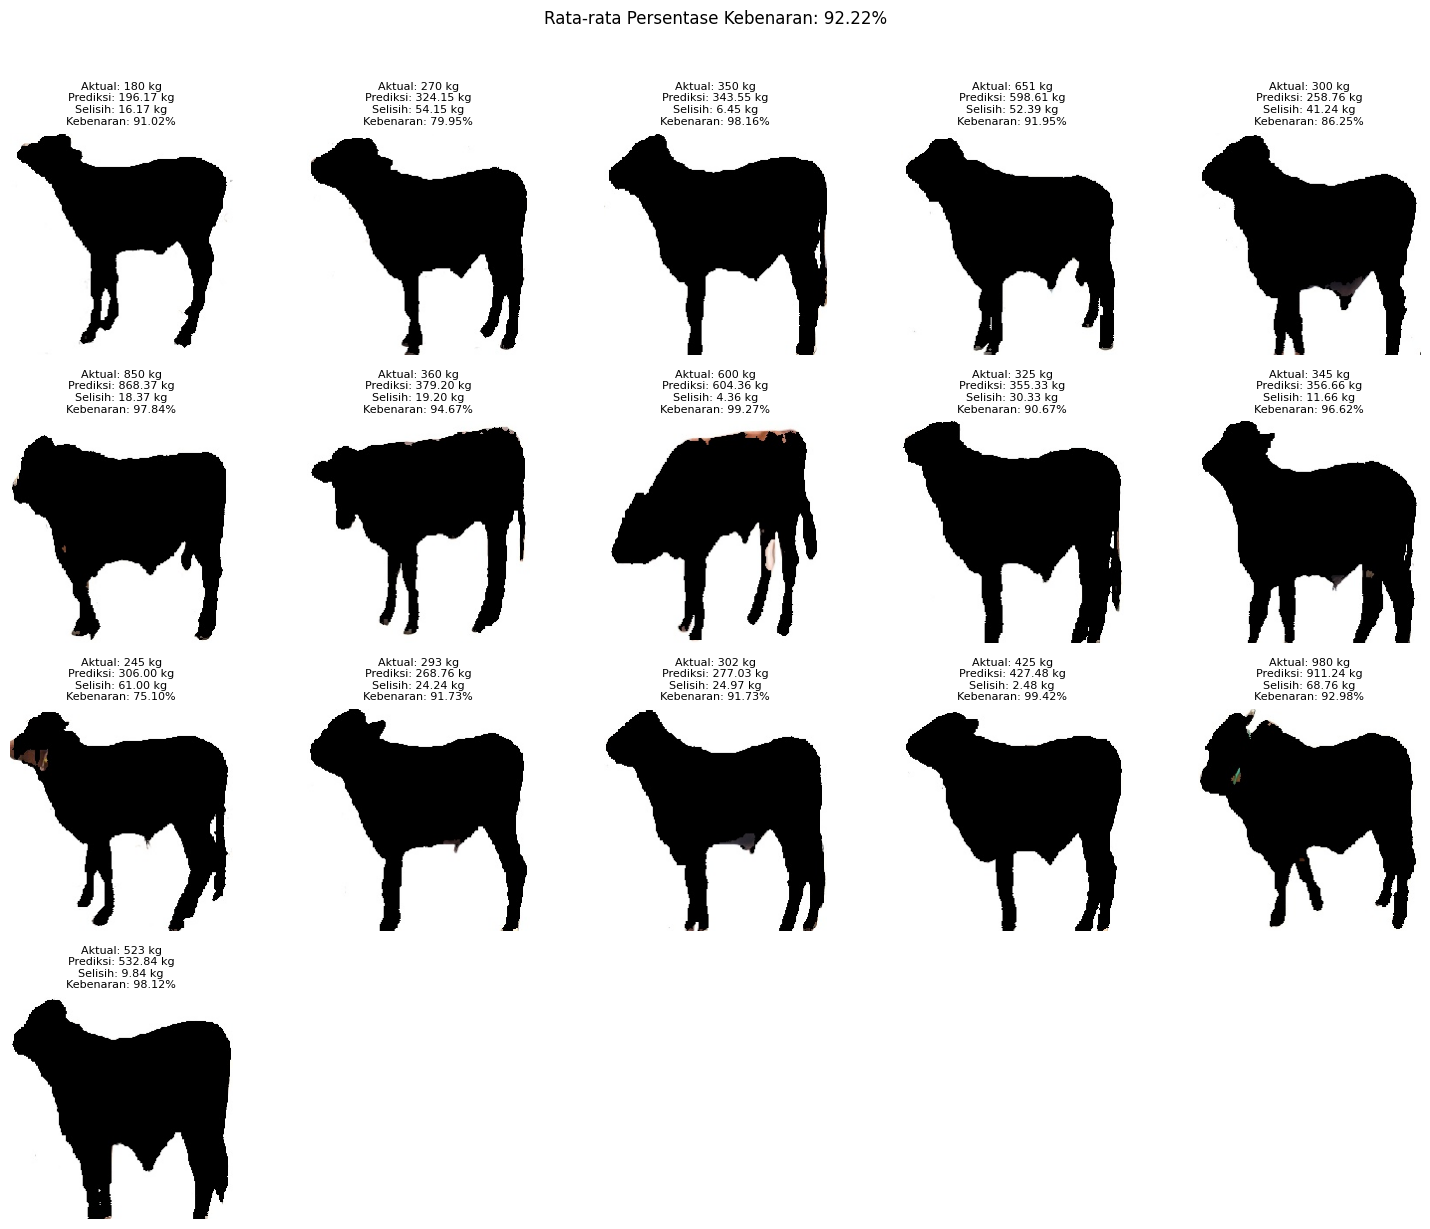

In [ ]:
import zipfile
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import math
import cv2

# Ekstrak file ZIP test
test_zip_path = '/content/dataset2.zip'
test_extract_path = '/content/'

with zipfile.ZipFile(test_zip_path, 'r') as zip_ref:
    zip_ref.extractall(test_extract_path)

print(f'File berhasil diekstrak ke {test_extract_path}')

# Load model segmentasi
segmentation_model = tf.keras.models.load_model('/content/segmentasi_model_unet_best.h5')

# Folder dataset
test_image_dir = '/content/dataset2'
test_segmented_dir = '/content/dataset2_segmented'
os.makedirs(test_segmented_dir, exist_ok=True)

SEGMENTATION_IMG_HEIGHT, SEGMENTATION_IMG_WIDTH = 256, 256
PREDICTION_IMG_HEIGHT, PREDICTION_IMG_WIDTH = 224, 224

def segment_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (SEGMENTATION_IMG_WIDTH, SEGMENTATION_IMG_HEIGHT)) / 255.0
    image_input = np.expand_dims(image, axis=0)
    pred_mask = segmentation_model.predict(image_input)[0]
    pred_mask = (pred_mask > 0.5).astype(np.uint8)

    segmented_image = image * np.expand_dims(pred_mask[:, :, 0], axis=-1)
    return segmented_image

images = []
labels = []

for filename in os.listdir(test_image_dir):
    if filename.endswith(".jpg"):
        img_path = os.path.join(test_image_dir, filename)
        segmented_image = segment_image(img_path)
        segmented_path = os.path.join(test_segmented_dir, filename)
        cv2.imwrite(segmented_path, cv2.cvtColor((segmented_image * 255).astype(np.uint8), cv2.COLOR_RGB2BGR))

        img_array = img_to_array(load_img(segmented_path, target_size=(PREDICTION_IMG_HEIGHT, PREDICTION_IMG_WIDTH))) / 255.0
        label = int(filename.split('.')[0])

        images.append(img_array)
        labels.append(label)

X = np.array(images)
y = np.array(labels)

# Load model prediksi bobot sapi
best_model = tf.keras.models.load_model('best_model.h5')
prediksi_bobot = best_model.predict(X)
selisih = np.abs(y - prediksi_bobot.flatten())
persentase_kebenaran = 100 * (1 - selisih / y)
rata_rata_persentase = np.mean(persentase_kebenaran)

num_images = len(X)
cols = 5
rows = math.ceil(num_images / cols)

plt.figure(figsize=(cols * 3, rows * 3))

for i in range(num_images):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(X[i])
    plt.axis('off')
    plt.title(f"Aktual: {y[i]} kg\nPrediksi: {prediksi_bobot[i][0]:.2f} kg\nSelisih: {selisih[i]:.2f} kg\nKebenaran: {persentase_kebenaran[i]:.2f}%", fontsize=8, color='black')

plt.suptitle(f"Rata-rata Persentase Kebenaran: {rata_rata_persentase:.2f}%", fontsize=12, y=1.02)
plt.tight_layout()
plt.show()

File berhasil diekstrak ke /content/


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


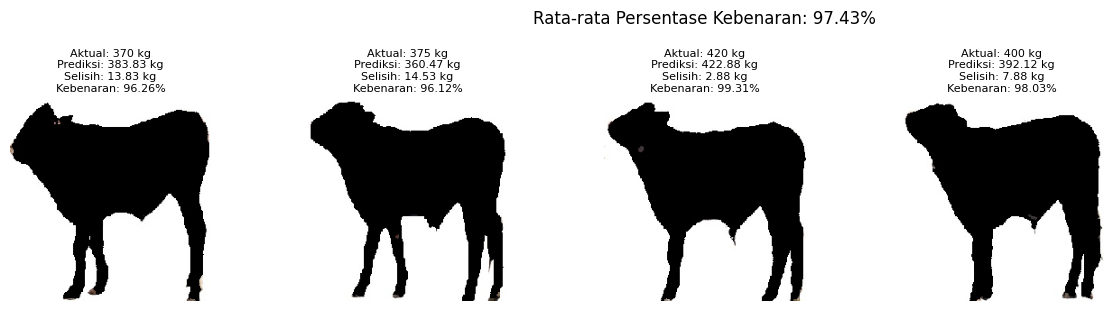

In [ ]:
import zipfile
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import math
import cv2

# Ekstrak file ZIP test
test_zip_path = '/content/test.zip'
test_extract_path = '/content/'

with zipfile.ZipFile(test_zip_path, 'r') as zip_ref:
    zip_ref.extractall(test_extract_path)

print(f'File berhasil diekstrak ke {test_extract_path}')

# Load model segmentasi
segmentation_model = tf.keras.models.load_model('/content/segmentasi_model_unet_best.h5')

# Folder dataset
test_image_dir = '/content/test'
test_segmented_dir = '/content/test_segmented'
os.makedirs(test_segmented_dir, exist_ok=True)

SEGMENTATION_IMG_HEIGHT, SEGMENTATION_IMG_WIDTH = 256, 256
PREDICTION_IMG_HEIGHT, PREDICTION_IMG_WIDTH = 224, 224

def segment_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (SEGMENTATION_IMG_WIDTH, SEGMENTATION_IMG_HEIGHT)) / 255.0
    image_input = np.expand_dims(image, axis=0)
    pred_mask = segmentation_model.predict(image_input)[0]
    pred_mask = (pred_mask > 0.5).astype(np.uint8)

    segmented_image = image * np.expand_dims(pred_mask[:, :, 0], axis=-1)
    return segmented_image

images = []
labels = []

for filename in os.listdir(test_image_dir):
    if filename.endswith(".jpg"):
        img_path = os.path.join(test_image_dir, filename)
        segmented_image = segment_image(img_path)
        segmented_path = os.path.join(test_segmented_dir, filename)
        cv2.imwrite(segmented_path, cv2.cvtColor((segmented_image * 255).astype(np.uint8), cv2.COLOR_RGB2BGR))

        img_array = img_to_array(load_img(segmented_path, target_size=(PREDICTION_IMG_HEIGHT, PREDICTION_IMG_WIDTH))) / 255.0
        label = int(filename.split('.')[0])

        images.append(img_array)
        labels.append(label)

X = np.array(images)
y = np.array(labels)

# Load model prediksi bobot sapi
best_model = tf.keras.models.load_model('best_model.h5')
prediksi_bobot = best_model.predict(X)
selisih = np.abs(y - prediksi_bobot.flatten())
persentase_kebenaran = 100 * (1 - selisih / y)
rata_rata_persentase = np.mean(persentase_kebenaran)

num_images = len(X)
cols = 5
rows = math.ceil(num_images / cols)

plt.figure(figsize=(cols * 3, rows * 3))

for i in range(num_images):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(X[i])
    plt.axis('off')
    plt.title(f"Aktual: {y[i]} kg\nPrediksi: {prediksi_bobot[i][0]:.2f} kg\nSelisih: {selisih[i]:.2f} kg\nKebenaran: {persentase_kebenaran[i]:.2f}%", fontsize=8, color='black')

plt.suptitle(f"Rata-rata Persentase Kebenaran: {rata_rata_persentase:.2f}%", fontsize=12, y=1.02)
plt.tight_layout()
plt.show()

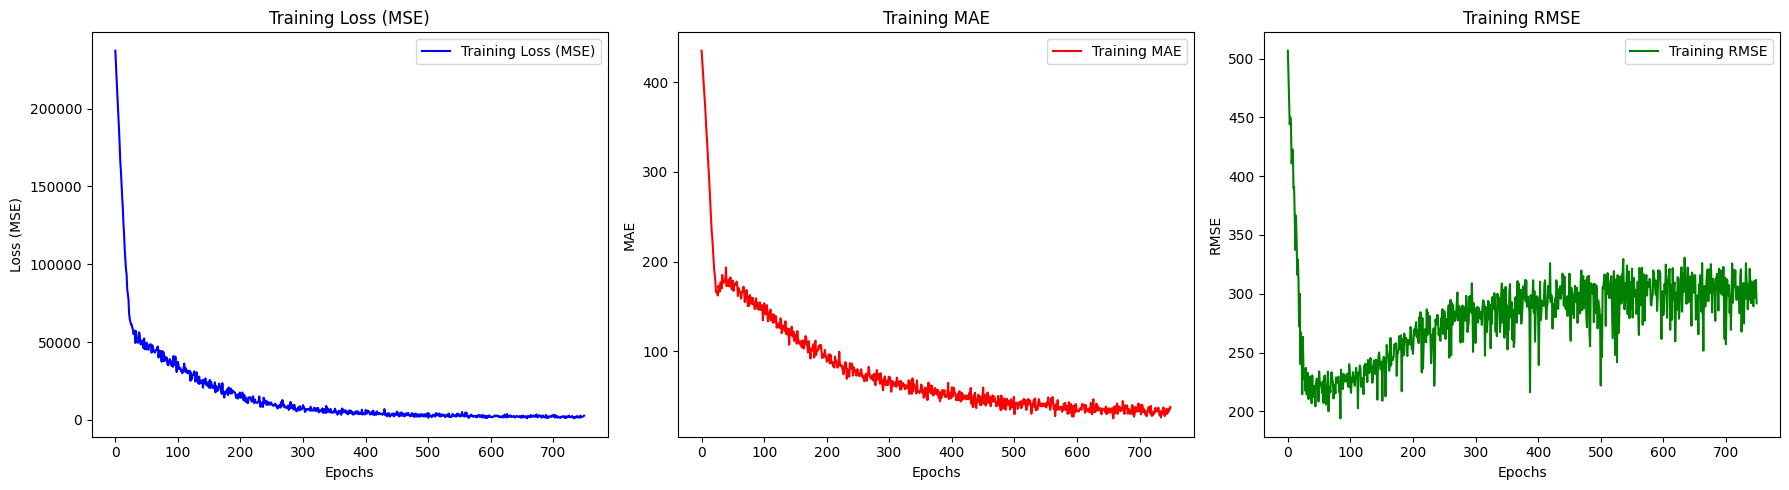

In [ ]:
plt.figure(figsize=(18, 5))

# Plot Loss (MSE)
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Training Loss (MSE)', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training Loss (MSE)')
plt.legend()

# Plot Mean Absolute Error (MAE)
plt.subplot(1, 3, 2)
plt.plot(history.history['mae'], label='Training MAE', color='red')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.title('Training MAE')
plt.legend()

# Plot Root Mean Squared Error (RMSE)
plt.subplot(1, 3, 3)
plt.plot(history.history['rmse'], label='Training RMSE', color='green')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.title('Training RMSE')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Ambil nilai MAE dan RMSE dari history
mae_values = history.history['mae']
rmse_values = history.history['rmse']

min_mae_index = mae_values.index(min(mae_values))

min_mae = mae_values[min_mae_index]
corresponding_rmse = rmse_values[min_mae_index]

print(f"MAE terkecil: {min_mae:.4f} pada epoch {min_mae_index + 1}")
print(f"RMSE pada epoch yang sama: {corresponding_rmse:.4f}")

MAE terkecil: 25.1030 pada epoch 659
RMSE pada epoch yang sama: 295.8353
